# Example 7: Full suite for NW Pacific

Let's take a look now at an oceanic area, where we should be using Free-air gravity anomaly data. This example should. produce estimates that are very close to those of Kalnins et al. (2009), although we use the parameter F as an additional model parameter (set to 0 in Kalnins et al. (2009)).

<div class="alert alert-block alert-warning">
<b>Warning:</b> These grids are fairly large and may require too much memory for the wavelet transform calculations. The estimation of flexural parameters over the whole grid will also be much slower. You can try to decimate the data original sets by a factor of two before starting the analysis if you run into memory problems. 
</div>

In [14]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid, FairGrid, ZcGrid, Project

# Read header (first line) of data set to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Bathy_PAC.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny to integers
nx = int(nx); ny = int(ny)

# Read data 
bathydata = pd.read_csv('../data/Bathy_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
fairdata = pd.read_csv('../data/Freeair_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Read data of crustal thickness
thickdata = pd.read_csv('../data/crustal_thickness_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# # Here we can reduce the size of the grids to make things easier to test
# bathydata = bathydata[100:356, 100:356]
# fairdata = fairdata[100:356, 100:356]
# thickdata = thickdata[100:356, 100:356]

All those data sets can be imported into their corresponding `Grid` objects:

grid contains NaN values. Performing interpolation...


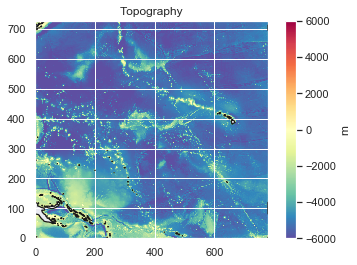

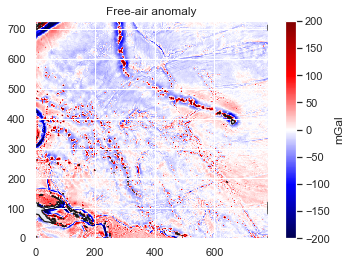

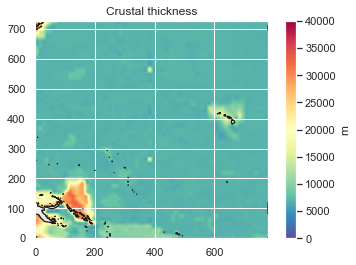

In [15]:
# Load the data as `TopoGrid` and `BougGrid` objects
bathy = TopoGrid(bathydata, dx, dy)
fair = FairGrid(fairdata, dx, dy)

# Create contours
contours = bathy.make_contours(0.)

# Make mask over land areas
mask = (bathy.data > 0.)

# Load the crustal thickness as `ZcGrid` object
thick = ZcGrid(thickdata, dx, dy)

# Plot the three data sets
bathy.plot(mask=mask, contours=contours, cmap='Spectral_r', vmin=-6000, vmax=6000)
fair.plot(mask=mask, contours=contours, cmap='seismic', vmin=-200, vmax=200)
thick.plot(mask=mask, contours=contours, cmap='Spectral_r', vmin=0., vmax=40000)

Filter water depth attribute and plot it

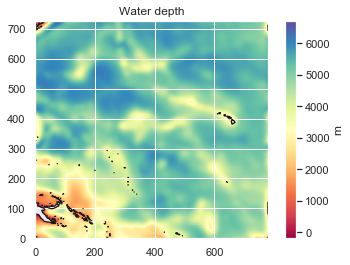

In [16]:
# Produce filtered version of water depth
bathy.filter_water_depth()
bathy.plot_water_depth(mask=mask, contours=contours, cmap='Spectral')

We would also like to set the value of crustal density, since it should be higher than 2700 kg/m^3 (default value). However, we don't have a `Grid` object for density, so let's fix a new global value:

In [17]:
# Import plateflex to change default variables
from plateflex.flex import conf_flex
conf_flex.rhoc = 2800.

Define the project with new `Grid` objects, initialize it and execute!

In [19]:
# Define new project
project = Project(grids=[bathy, fair, thick])

# Initialize project
project.init()

# Calculate wavelet admittance and coherence
project.wlet_admit_coh()

# Make sure we are using 'L2'
project.inverse = 'L2'

# Insert mask
project.mask = mask

# Estimate flexural parameters at every 10 points of the initial grid
project.estimate_grid(5, atype='admit')

Computing: [##########] 145/145


Now plot everything

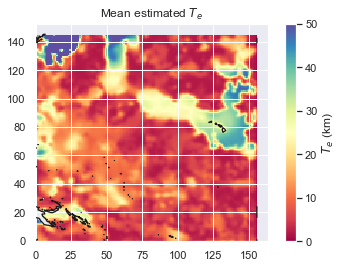

In [22]:
project.plot_results(mean_Te=True, mask=True, contours=contours, cmap='Spectral', vmin=0., vmax=50.)

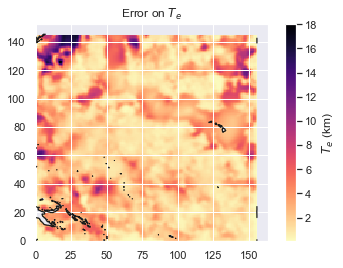

In [23]:
project.plot_results(std_Te=True, mask=True, contours=contours, cmap='magma_r')

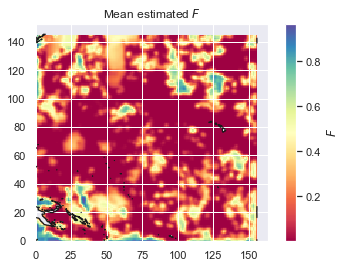

In [24]:
project.plot_results(mean_F=True, mask=True, contours=contours, cmap='Spectral')

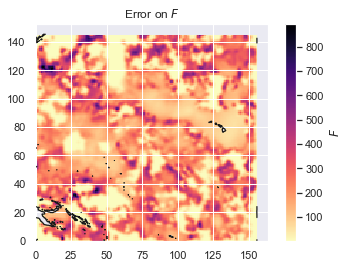

In [25]:
project.plot_results(std_F=True, mask=True, contours=contours, cmap='magma_r')

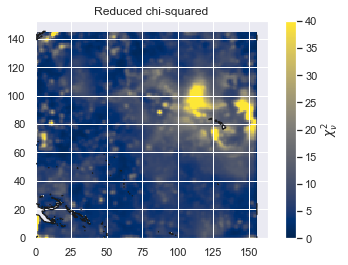

In [26]:
project.plot_results(chi2=True, mask=True, contours=contours, cmap='cividis', vmin=0, vmax=40)

Now try again with `atype='coh'` to test the effect of using a single function. After that try one more time with `atype='joint'`.